# Cluster 17

In [1]:
import gizmo_analysis as gizmo
import utilities as ut
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
#from mpl_toolkits.mplot3d import Axes3D
from sl_utilities import distinct_colours as dc
from sl_utilities import distance_functions
import os
import pickle
from fof_analysis import fof
from mycolorpy import colorlist as mcp
from matplotlib.ticker import AutoMinorLocator


In [2]:
!hostname
!pwd
!pip show mycolorpy
!which python

c506-093.stampede2.tacc.utexas.edu
/home1/07428/binod
Name: mycolorpy
Version: 1.5.0
Summary: Create of array of colors from a colormap
Home-page: https://github.com/binodbhttr/mycolorpy
Author: Binod Bhattarai
Author-email: info@binodb.com.np
License: MIT
Location: /home1/07428/binod/anaconda3/lib/python3.8/site-packages
Requires: matplotlib, numpy
Required-by: 
/home1/07428/binod/anaconda3/bin/python


In [3]:
simname = 'm12i_res7100_mhdcv'
simdir = '/scratch/projects/xsede/GalaxiesOnFIRE/cr_suite/m12i_res7100/mhdcv/1Myr/fire2/'
simtype="fire2"
snapnumber=596
snap=snapnumber

#data_path="/home1/07428/binod/stampede_workfolder/fire2/fire2_data_pkl/" 
#gas_datapath="/home1/07428/binod/stampede_workfolder/fire2/fire2_gas_data_pkl/"

#gas_file_name=simtype+"_gas_data"+str(snapnumber)+".pkl"
#cluster_data_name="all_clusters_at_snapshot_"+str(snapnumber)+".pkl" 

#############################################################################
#constants
#############################################################################

MsunToGm = 1.99e33
KpcToCm = 3.086e21
mp = 1.67e-24
#bin_edge = 10.
bin_edge = 30.

bins = np.arange(-5,5,0.1)
#bins = np.arange(-25,25,0.1)


# Extracting age, location and metallicity information for the simulations

In [4]:
part=gizmo.io.Read.read_snapshots(['star'],'snapshot_index', snap, simulation_name=simname, simulation_directory=simdir, assign_hosts=True, assign_hosts_rotation=True)               #snap is the snapshot number here that changes everytime the loop iterates. It starts with sanpshot_start

age=part['star'].prop('age')
x=part['star'].prop('host.distance.principal')[:,0] #x component of the position of all stars 
y=part['star'].prop('host.distance.principal')[:,1] #y component of the position of all stars
z=part['star'].prop('host.distance.principal')[:,2] #z component of the position of all stars
Rxy = part['star'].prop('host.distance.principal.cylindrical')[:,0]
rxyz     = part['star'].prop('host.distance.total')
mass     = part['star'].prop('mass')

ids      = part['star'].prop('id')
id_child = part['star'].prop('id.child')
age      = part['star'].prop('age')
#Eleven total chemical species (H, He, C, N, O, Ne, Mg, Si, S, Ca, Fe)
ch      = part['star'].prop('metallicity.c')
nh      = part['star'].prop('metallicity.n')
oh      = part['star'].prop('metallicity.o') #oxygen
neh      = part['star'].prop('metallicity.ne')
mgh = part['star'].prop('metallicity.mg') #magnesium
sih      = part['star'].prop('metallicity.si') # silicon
sh      = part['star'].prop('metallicity.s')
cah      = part['star'].prop('metallicity.ca') #calcium
feh = part['star'].prop('metallicity.fe') #iron
mgfe    = part['star'].prop('metallicity.mg - metallicity.fe')
sife    = part['star'].prop('metallicity.si - metallicity.fe')
cafe    = part['star'].prop('metallicity.ca - metallicity.fe')
ofe    = part['star'].prop('metallicity.o - metallicity.fe')
sfe    = part['star'].prop('metallicity.s - metallicity.fe')
nefe    = part['star'].prop('metallicity.ne - metallicity.fe')


# in utilities.simulation.Snapshot():
* reading:  scratch/projects/xsede/GalaxiesOnFIRE/cr_suite/m12i_res7100/mhdcv/1Myr/fire2/snapshot_times.txt

  using snapshot index = 596, redshift = 0.007


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  scratch/projects/xsede/GalaxiesOnFIRE/cr_suite/m12i_res7100/mhdcv/1Myr/fire2/output/snapdir_596/snapshot_596.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 70514272 particles
    dark2     (id = 2): 5513331 particles
    gas       (id = 0): 55685704 particles
    star      (id = 4): 15298647 particles
    blackhole (id = 5): 0 particles

* reading species: ['star']
* reading particles from:
    snapshot_596.0.hdf5
    snapshot_596.1.hdf5
    snapshot_596.2.hdf5
    snapshot_596.3.hdf5

* reading cosmological parameters from:  scratch/projects/xsede/GalaxiesOnFIRE/cr_suite/m12i_res7100/mhdcv/1Myr/fire2/initial_condition/ic_agora_m12i.conf

* checking sanity of particle properties
! warning: star

In [5]:
#select young stars within the disk for star clusters
keep = np.where((age <= .003) & ((Rxy < 20) & (Rxy>2)) & (abs(z) < 1.5))
#to run cluster finding on
rxyz0     = rxyz[keep]
Rxy0      = Rxy[keep]
x0        = x[keep]
y0        = y[keep]
z0        = z[keep]
mass0     = mass[keep]
feh0      = feh[keep]
mgh0      = mgh[keep]
ch0=ch[keep]
nh0=nh[keep]
oh0=oh[keep]
neh0=neh[keep]
sih0=sih[keep]
sh0=sh[keep]
cah0=cah[keep]
mgfe0=mgfe[keep]
ofe0=ofe[keep]
sife0=sife[keep]
cafe0=cafe[keep]
sfe0=sfe[keep]
nefe0=nefe[keep]
id0       = ids[keep]
id_child0 = id_child[keep]
age0      = age[keep]

In [6]:
linking_length = 0.01 #10 parsec (unit here is in kpc)
ncut           = 10 #5 star particles
ind, xcm, ycm, zcm, mtot, grpid, r90, r50, rmax =fof.find(x0,y0,z0, b=linking_length, mass=mass0, ncut=ncut)
ngroup = len(mtot)

linking length  0.01
min number particles in group  10
0.08329153060913086 seconds
number of groups 16
max number in a group 43


# Loading cluster data and gas data

In [7]:
export_cluster={}
for grp_index in range(ngroup):  #iterate over each group
    cluster={}
    ids_in_cluster = id0[ind[grp_index]]  #these are the star particle ids in each cluster
    id_children_in_cluster = id_child0[ind[grp_index]]
    age_cluster=age0[ind[grp_index]]
    nstar = len(ids_in_cluster)
    groupid=grpid[grp_index]
    print('------------------------------------------------------------------------------------------------------------------')
    print('grpid, nstar, xcm (kpc), ycm (kpc), zcm (kpc), mtot (msun), rmax (pc)')
    print('%s     %i     %.4f     %.4f    %.4f     %.2e     %.1f ' % (grpid[grp_index], nstar, xcm[grp_index], ycm[grp_index], zcm[grp_index], mtot[grp_index], 1000*rmax[grp_index]))
    print("age of stars in the cluster",age_cluster)
    print('ids')
    string = '[' 
    for i in ids_in_cluster:
        string = string + str(i) + ', '

    #get rid of last extra ,
    length = len(string)-2
    string = string[0:length] + ']'
    print(string)

    print('id children')
    string = '[' 
    for i in id_children_in_cluster:
        string = string + str(i) + ', '

    #get rid of last extra ,
    length = len(string)-2
    string = string[0:length] + ']'
    print(string)
    print("These are the ids printed",ids_in_cluster)
    #feh_in_cluster=feh0[ind[grp_index]]
    #cluster={"cluster_groupid":groupid,"no_of_star":nstar,"id":ids_in_cluster,"id_children":id_children_in_cluster,"xcm":xcm[grp_index],"ycm":ycm[grp_index],"zcm":zcm[grp_index],"mtot":mtot[grp_index],"r90":r90[grp_index],"r50":r50[grp_index],"rmax":rmax[grp_index],"x":x0[ind[grp_index]],"y":y0[ind[grp_index]],"z":z0[ind[grp_index]],"age":age0[ind[grp_index]],"feh":feh0[ind[grp_index]],"mgh":mgh0[ind[grp_index]],"ch":ch0[ind[grp_index]],"nh":nh0[ind[grp_index]],"oh":oh0[ind[grp_index]],"neh":neh0[ind[grp_index]],"sih":sih0[ind[grp_index]],"sh":sh0[ind[grp_index]],"cah":cah0[ind[grp_index]],"mgfe":mgfe0[ind[grp_index]],"ofe":ofe0[ind[grp_index]],"sife":sife0[ind[grp_index]],"sfe":sfe0[ind[grp_index]],"cafe":cafe0[ind[grp_index]],"nefe":nefe0[ind[grp_index]]}
    cluster={"cluster_groupid":groupid,"no_of_star":nstar,"id":ids_in_cluster,"id_children":id_children_in_cluster,"xcm":xcm[grp_index],"ycm":ycm[grp_index],"zcm":zcm[grp_index],"mtot":mtot[grp_index],"r90":r90[grp_index],"r50":r50[grp_index],"rmax":rmax[grp_index],"x":x0[ind[grp_index]],"y":y0[ind[grp_index]],"z":z0[ind[grp_index]],"age":age0[ind[grp_index]],"feh":feh0[ind[grp_index]],"mgh":mgh0[ind[grp_index]],"ch":ch0[ind[grp_index]],"nh":nh0[ind[grp_index]],"oh":oh0[ind[grp_index]],"neh":neh0[ind[grp_index]],"sih":sih0[ind[grp_index]],"sh":sh0[ind[grp_index]],"cah":cah0[ind[grp_index]],"mgfe":mgfe0[ind[grp_index]],"ofe":ofe0[ind[grp_index]],"sife":sife0[ind[grp_index]],"sfe":sfe0[ind[grp_index]],"cafe":cafe0[ind[grp_index]],"nefe":nefe0[ind[grp_index]]}
    export_cluster.update({groupid:cluster})


------------------------------------------------------------------------------------------------------------------
grpid, nstar, xcm (kpc), ycm (kpc), zcm (kpc), mtot (msun), rmax (pc)
1     43     -6.0073     6.0728    0.1123     4.95e+05     14.0 
age of stars in the cluster [2.24651479e-04 8.28341143e-04 1.34115589e-03 3.98085611e-04
 9.12414719e-05 1.52109695e-04 1.57946382e-04 8.28341143e-04
 1.05431180e-03 2.24651479e-04 2.13811888e-04 2.34657260e-04
 3.98085611e-04 3.78073916e-04 9.10891061e-04 6.84921765e-04
 1.40202732e-03 5.41503254e-04 1.95571435e-03 7.46625344e-04
 1.11252925e-04 8.04019418e-05 1.52109695e-04 1.13602866e-03
 5.21491438e-04 1.38201478e-03 8.69440557e-06 1.72955012e-04
 5.62348914e-04 3.88079761e-04 1.50459187e-03 1.62800345e-03
 2.54668835e-04 1.01247196e-04 6.03905145e-05 8.04019418e-05
 1.95339030e-05 1.22092469e-04 1.62949258e-04 1.72955012e-04
 2.34657260e-04 2.95395972e-05 1.25860448e-03]
ids
[21964074, 13285005, 30978536, 68630449, 45857179, 47786639, 

In [8]:
cluster_group=1
export_cluster[cluster_group].keys()

dict_keys(['cluster_groupid', 'no_of_star', 'id', 'id_children', 'xcm', 'ycm', 'zcm', 'mtot', 'r90', 'r50', 'rmax', 'x', 'y', 'z', 'age', 'feh', 'mgh', 'ch', 'nh', 'oh', 'neh', 'sih', 'sh', 'cah', 'mgfe', 'ofe', 'sife', 'sfe', 'cafe', 'nefe'])

In [9]:
ind=export_cluster[1]["feh"]
print(feh)
print(export_cluster[1]["x"])
print(export_cluster[1]["r90"])


[-2.0814083 -1.21252   -1.3928102 ... -1.169801  -1.2236117 -1.7191033]
[-6.00307966 -6.00349799 -5.99988107 -6.00310962 -6.0017005  -6.00654862
 -6.00698674 -6.00554434 -6.0050974  -6.00808298 -6.00762546 -6.00812528
 -6.01068292 -6.00328777 -6.00619153 -6.00745984 -6.00777392 -6.00678715
 -6.0006055  -6.00562482 -6.00646929 -6.00540532 -6.00503285 -6.00668641
 -6.00979852 -6.00419566 -6.00853963 -6.00964962 -6.0024964  -6.00964411
 -6.01415946 -6.0062386  -6.00951576 -6.00939451 -6.01092185 -6.01307867
 -6.00950509 -6.00960962 -6.00954438 -6.00964288 -6.01100886 -6.01159239
 -6.01534861]
0.009604226707545014


# Locating the CM of the cluster

In [10]:
xcm=export_cluster[cluster_group]["xcm"]
ycm=export_cluster[cluster_group]["ycm"]
print("The cluster is located at:",(xcm,ycm))
radius=((xcm)**2+(ycm)**2)**(1/2)
print("The cluster CM is at radius: ",radius)

circle_radius=((x-xcm)**2+(y-ycm)**2)**(1/2)
print(len(circle_radius))

cm_R=list()
for i in export_cluster:
    xcm=export_cluster[i]["xcm"]
    ycm=export_cluster[i]["ycm"]
    radius=((xcm)**2+(ycm)**2)**(1/2)
    cm_R.append(radius)
    

print(cm_R)
cm_R=np.array(cm_R)


The cluster is located at: (-6.007335501751587, 6.072812012658155)
The cluster CM is at radius:  8.542079698275485
15298647
[8.542079698275485, 8.377818342008291, 7.269312278960123, 9.121051204780578, 7.568216071203412, 6.05867245602863, 7.298719833188445, 13.090947848338857, 4.174343238454306, 7.160994715543686, 6.426306455847568, 7.8935588338106015, 4.009661754254098, 13.030381289833587, 5.461061312766238, 12.924026626242185]


In [11]:
region=np.linspace(1,20,20)/10
print(region)
print(cluster_group)


[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8
 1.9 2. ]
1


# Age less than 3 Myr


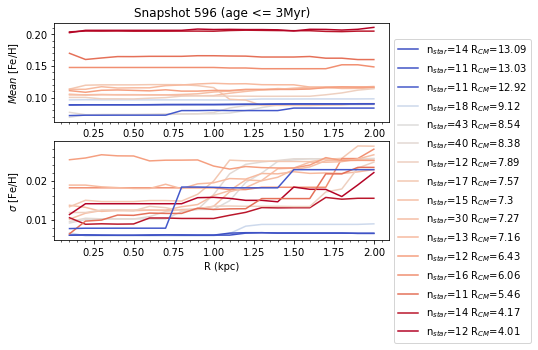

In [34]:
#colors=['cyan','blue','green','magenta','yellow','teal','brown','darkslategray','lime','red','orange','purple','rosybrown','pink','navy','olive','cornflowerblue','blueviolet','darkgreen'] #19 colors
colors=mcp.gen_color_normalized(cmap="coolwarm",data_arr=cm_R,reverse=True)
fig1=plt.figure()
ax=fig1.add_subplot(212)
ax0=fig1.add_subplot(211)

for cluster_group in export_cluster:
    sigma_f=list()
    mean_f=list()
    xcm=export_cluster[cluster_group]["xcm"]
    ycm=export_cluster[cluster_group]["ycm"]
    r90_cluster=export_cluster[cluster_group]["r90"]
    cluster_feh=export_cluster[cluster_group]["feh"]
    cluster_feh_sigma=np.std(cluster_feh)
    radius=((xcm)**2+(ycm)**2)**(1/2)
    #print("The cluster CM is at radius: ",round(radius,2))
    circle_radius=((x-xcm)**2+(y-ycm)**2)**(1/2)
    for r in region:
        keep = np.where((age <= .003) & (circle_radius<=r) & (abs(z) < 1.5))
        feh_region=feh[keep]
        sigma_feh_region=np.std(feh_region)
        mean_feh_region=np.mean(feh_region)
        sigma_f.append(sigma_feh_region)
        mean_f.append(mean_feh_region)

    #print(sigma_f)
    nstar=len(export_cluster[cluster_group]["x"])
    label_text=r"n$_{star}$="+str(nstar)+r" R$_{CM}$="+str(round(radius,2))
    ax.plot(region,sigma_f,label=label_text,c=colors[cluster_group-1])
    ax0.plot(region,mean_f,label=label_text,c=colors[cluster_group-1])

    #ax.scatter(r90_cluster,cluster_feh_sigma,marker="*",c=colors[cluster_group-1])

ax.set_xlabel("R (kpc)")
ax.set_ylabel(r"$\sigma$ [Fe/H]")
ax.minorticks_on()

handles,labels = ax.get_legend_handles_labels()
sorted_handles= [x for _,x in sorted(zip(cm_R,handles),reverse=True)] #sort the handles (the colors next to the labels) based on location of CM
sorted_legends= [x for _,x in sorted(zip(cm_R,labels),reverse=True)] #sort the labels based on cm_R which is a list
ax.legend(sorted_handles,sorted_legends,bbox_to_anchor=(1,0.5), loc='center left')

ax0.set_title("Snapshot "+str(snapnumber)+" (age <= 3Myr)")
#ax0.set_xlabel("R (kpc)")
ax0.set_ylabel(r"$Mean$ [Fe/H]")
ax0.minorticks_on()
fig1.savefig(str(snapnumber)+"sigma_feh_Age3Myr.jpg",bbox_inches='tight',dpi=200)
plt.show()

# SIGMA Fe/H Age<=10 Myr

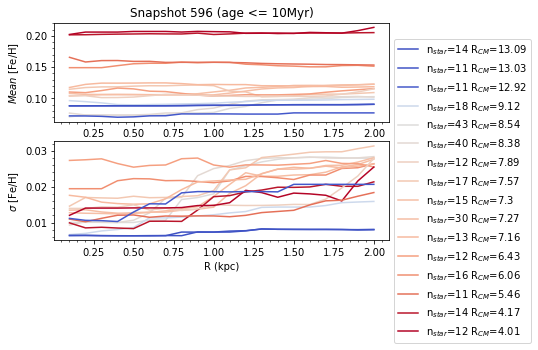

In [35]:
#colors=['cyan','blue','green','magenta','yellow','teal','brown','darkslategray','lime','red','orange','purple','rosybrown','pink','navy','olive','cornflowerblue','blueviolet','darkgreen'] #19 colors
colors=mcp.gen_color_normalized(cmap="coolwarm",data_arr=cm_R,reverse=True)
fig1=plt.figure()
ax=fig1.add_subplot(212)
ax0=fig1.add_subplot(211)

for cluster_group in export_cluster:
    sigma_f=list()
    mean_f=list()
    xcm=export_cluster[cluster_group]["xcm"]
    ycm=export_cluster[cluster_group]["ycm"]
    r90_cluster=export_cluster[cluster_group]["r90"]
    cluster_feh=export_cluster[cluster_group]["feh"]
    cluster_feh_sigma=np.std(cluster_feh)
    radius=((xcm)**2+(ycm)**2)**(1/2)
    #print("The cluster CM is at radius: ",round(radius,2))
    circle_radius=((x-xcm)**2+(y-ycm)**2)**(1/2)
    for r in region:
        keep = np.where((age <= .010) & (circle_radius<=r) & (abs(z) < 1.5))
        feh_region=feh[keep]
        sigma_feh_region=np.std(feh_region)
        mean_feh_region=np.mean(feh_region)
        sigma_f.append(sigma_feh_region)
        mean_f.append(mean_feh_region)

    #print(sigma_f)
    nstar=len(export_cluster[cluster_group]["x"])
    label_text=r"n$_{star}$="+str(nstar)+r" R$_{CM}$="+str(round(radius,2))
    ax.plot(region,sigma_f,label=label_text,c=colors[cluster_group-1])
    ax0.plot(region,mean_f,label=label_text,c=colors[cluster_group-1])

    #ax.scatter(r90_cluster,cluster_feh_sigma,marker="*",c=colors[cluster_group-1])

ax.set_xlabel("R (kpc)")
ax.set_ylabel(r"$\sigma$ [Fe/H]")
ax.minorticks_on()

handles,labels = ax.get_legend_handles_labels()
sorted_handles= [x for _,x in sorted(zip(cm_R,handles),reverse=True)] #sort the handles (the colors next to the labels) based on location of CM
sorted_legends= [x for _,x in sorted(zip(cm_R,labels),reverse=True)] #sort the labels based on cm_R which is a list
ax.legend(sorted_handles,sorted_legends,bbox_to_anchor=(1,0.5), loc='center left')

ax0.set_title("Snapshot "+str(snapnumber)+" (age <= 10Myr)")
#ax0.set_xlabel("R (kpc)")
ax0.set_ylabel(r"$Mean$ [Fe/H]")
ax0.minorticks_on()
fig1.savefig(str(snapnumber)+"sigma_feh_age10Myr.jpg",bbox_inches='tight',dpi=200)
plt.show()

# Sigma over root N age <=3 Myr 

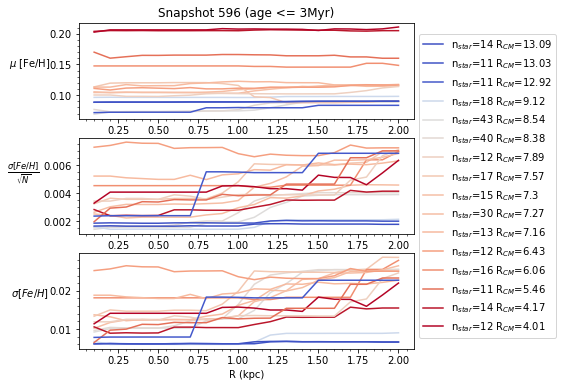

In [36]:
#colors=['cyan','blue','green','magenta','yellow','teal','brown','darkslategray','lime','red','orange','purple','rosybrown','pink','navy','olive','cornflowerblue','blueviolet','darkgreen'] #19 colors
colors=mcp.gen_color_normalized(cmap="coolwarm",data_arr=cm_R,reverse=True)
fig1=plt.figure(figsize=(6,6))
ax=fig1.add_subplot(312)
ax0=fig1.add_subplot(311)
ax1=fig1.add_subplot(313)


for cluster_group in export_cluster:
    sigma_f=list()
    mean_f=list()
    xcm=export_cluster[cluster_group]["xcm"]
    ycm=export_cluster[cluster_group]["ycm"]
    r90_cluster=export_cluster[cluster_group]["r90"]
    cluster_feh=export_cluster[cluster_group]["feh"]
    cluster_feh_sigma=np.std(cluster_feh)
    radius=((xcm)**2+(ycm)**2)**(1/2)
    #print("The cluster CM is at radius: ",round(radius,2))
    circle_radius=((x-xcm)**2+(y-ycm)**2)**(1/2)
    for r in region:
        keep = np.where((age <= .003) & (circle_radius<=r) & (abs(z) < 1.5))
        feh_region=feh[keep]
        sigma_feh_region=np.std(feh_region)
        mean_feh_region=np.mean(feh_region)
        sigma_f.append(sigma_feh_region)
        mean_f.append(mean_feh_region)

    #print(sigma_f)
    nstar=len(export_cluster[cluster_group]["x"])
    label_text=r"n$_{star}$="+str(nstar)+r" R$_{CM}$="+str(round(radius,2))
    sigma_f_rootN=np.array(sigma_f)/(nstar**(1/2))
    ax.plot(region,sigma_f_rootN,label=label_text,c=colors[cluster_group-1])
    ax0.plot(region,mean_f,label=label_text,c=colors[cluster_group-1])
    ax1.plot(region,sigma_f,label=label_text,c=colors[cluster_group-1])
    #ax.scatter(r90_cluster,cluster_feh_sigma,marker="*",c=colors[cluster_group-1])

ax.set_xlabel("R (kpc)")
ax.set_ylabel(r"$\frac{\sigma [Fe/H]}{\sqrt{N}}$",fontsize=12,rotation=0,labelpad=20)
ax.minorticks_on()

ax1.set_xlabel("R (kpc)")
ax1.set_ylabel(r"$\sigma [Fe/H]$",rotation=0,labelpad=20)
ax1.minorticks_on()

handles,labels = ax.get_legend_handles_labels()
sorted_handles= [x for _,x in sorted(zip(cm_R,handles),reverse=True)] #sort the handles (the colors next to the labels) based on location of CM
sorted_legends= [x for _,x in sorted(zip(cm_R,labels),reverse=True)] #sort the labels based on cm_R which is a list
ax.legend(sorted_handles,sorted_legends,bbox_to_anchor=(1,0.5), loc='center left')

ax0.set_title("Snapshot "+str(snapnumber)+" (age <= 3Myr)")
#ax0.set_xlabel("R (kpc)")
ax0.set_ylabel(r"$\mu$ [Fe/H]",rotation=0,labelpad=20)
ax0.minorticks_on()
fig1.savefig(str(snapnumber)+"sigma_feh_by_rootN_region_2kpc_Age_3Myr.jpg",dpi=200,bbox_inches="tight") #bbox_inches="tight"
plt.show()

# Sigma over root N (age <10 Myr)

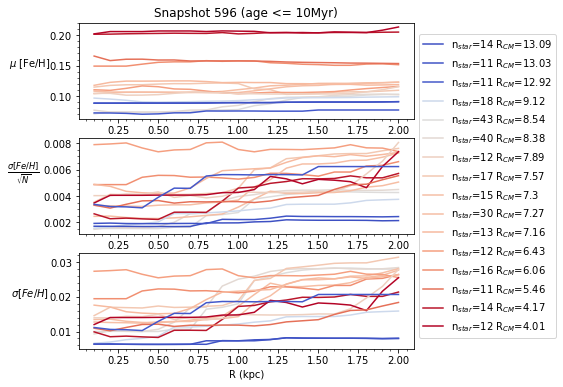

In [37]:
#colors=['cyan','blue','green','magenta','yellow','teal','brown','darkslategray','lime','red','orange','purple','rosybrown','pink','navy','olive','cornflowerblue','blueviolet','darkgreen'] #19 colors
colors=mcp.gen_color_normalized(cmap="coolwarm",data_arr=cm_R,reverse=True)
fig1=plt.figure(figsize=(6,6))
ax=fig1.add_subplot(312)
ax0=fig1.add_subplot(311)
ax1=fig1.add_subplot(313)


for cluster_group in export_cluster:
    sigma_f=list()
    mean_f=list()
    xcm=export_cluster[cluster_group]["xcm"]
    ycm=export_cluster[cluster_group]["ycm"]
    r90_cluster=export_cluster[cluster_group]["r90"]
    cluster_feh=export_cluster[cluster_group]["feh"]
    cluster_feh_sigma=np.std(cluster_feh)
    radius=((xcm)**2+(ycm)**2)**(1/2)
    #print("The cluster CM is at radius: ",round(radius,2))
    circle_radius=((x-xcm)**2+(y-ycm)**2)**(1/2)
    for r in region:
        keep = np.where((age <= .010) & (circle_radius<=r) & (abs(z) < 1.5))
        feh_region=feh[keep]
        sigma_feh_region=np.std(feh_region)
        mean_feh_region=np.mean(feh_region)
        sigma_f.append(sigma_feh_region)
        mean_f.append(mean_feh_region)

    #print(sigma_f)
    nstar=len(export_cluster[cluster_group]["x"])
    label_text=r"n$_{star}$="+str(nstar)+r" R$_{CM}$="+str(round(radius,2))
    sigma_f_rootN=np.array(sigma_f)/(nstar**(1/2))
    ax.plot(region,sigma_f_rootN,label=label_text,c=colors[cluster_group-1])
    ax0.plot(region,mean_f,label=label_text,c=colors[cluster_group-1])
    ax1.plot(region,sigma_f,label=label_text,c=colors[cluster_group-1])
    #ax.scatter(r90_cluster,cluster_feh_sigma,marker="*",c=colors[cluster_group-1])

ax.set_xlabel("R (kpc)")
ax.set_ylabel(r"$\frac{\sigma [Fe/H]}{\sqrt{N}}$",fontsize=12,rotation=0,labelpad=20)
ax.minorticks_on()

ax1.set_xlabel("R (kpc)")
ax1.set_ylabel(r"$\sigma [Fe/H]$",rotation=0,labelpad=20)
ax1.minorticks_on()

handles,labels = ax.get_legend_handles_labels()
sorted_handles= [x for _,x in sorted(zip(cm_R,handles),reverse=True)] #sort the handles (the colors next to the labels) based on location of CM
sorted_legends= [x for _,x in sorted(zip(cm_R,labels),reverse=True)] #sort the labels based on cm_R which is a list
ax.legend(sorted_handles,sorted_legends,bbox_to_anchor=(1,0.5), loc='center left')

ax0.set_title("Snapshot "+str(snapnumber)+" (age <= 10Myr)")
#ax0.set_xlabel("R (kpc)")
ax0.set_ylabel(r"$\mu$ [Fe/H]",rotation=0,labelpad=20)
ax0.minorticks_on()
fig1.savefig(str(snapnumber)+"sigma_feh_by_rootN_region_2kpc_Age_10Myr.jpg",dpi=200,bbox_inches="tight") #bbox_inches="tight"
plt.show()

# Mgh

The cluster CM is at radius:  8.542079698275485
The cluster CM is at radius:  8.377818342008291
The cluster CM is at radius:  7.269312278960123
The cluster CM is at radius:  9.121051204780578
The cluster CM is at radius:  7.568216071203412
The cluster CM is at radius:  6.05867245602863
The cluster CM is at radius:  7.298719833188445
The cluster CM is at radius:  13.090947848338857
The cluster CM is at radius:  4.174343238454306
The cluster CM is at radius:  7.160994715543686
The cluster CM is at radius:  6.426306455847568
The cluster CM is at radius:  7.8935588338106015
The cluster CM is at radius:  4.009661754254098
The cluster CM is at radius:  13.030381289833587
The cluster CM is at radius:  5.461061312766238
The cluster CM is at radius:  12.924026626242185


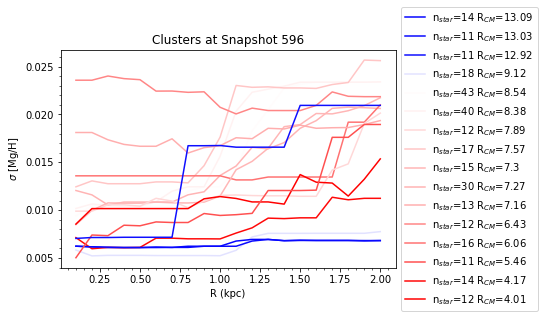

In [38]:
#colors=['cyan','blue','green','magenta','yellow','teal','brown','darkslategray','lime','red','orange','purple','rosybrown','pink','navy','olive','cornflowerblue','blueviolet','darkgreen'] #19 colors
colors=mcp.gen_color_normalized(cmap="bwr",data_arr=cm_R,reverse=True)

fig1=plt.figure()
ax=fig1.add_subplot(111)

for cluster_group in export_cluster:
    sigma_mgh=list()
    xcm=export_cluster[cluster_group]["xcm"]
    ycm=export_cluster[cluster_group]["ycm"]
    r90_cluster=export_cluster[cluster_group]["r90"]
    cluster_mgh=export_cluster[cluster_group]["mgh"]
    cluster_mgh_sigma=np.std(cluster_mgh)
    radius=((xcm)**2+(ycm)**2)**(1/2)
    print("The cluster CM is at radius: ",radius)
    circle_radius=((x-xcm)**2+(y-ycm)**2)**(1/2)
    for r in region:
        keep = np.where((age <= .003) & (circle_radius<=r) & (abs(z) < 1.5))
        mgh_region=mgh[keep]
        sigma_mgh_region=np.std(mgh_region)
        sigma_mgh.append(sigma_mgh_region)

    #print(sigma_mgh)
    nstar=len(export_cluster[cluster_group]["x"])
    label_text=r"n$_{star}$="+str(nstar)+r" R$_{CM}$="+str(round(radius,2))
    ax.plot(region,sigma_mgh,label=label_text,c=colors[cluster_group-1])
    #ax.scatter(r90_cluster,cluster_mgh_sigma,marker="*",c=colors[cluster_group-1])

ax.set_xlabel("R (kpc)")
ax.set_ylabel(r"$\sigma$ [Mg/H]")
ax.minorticks_on()
handles,labels = ax.get_legend_handles_labels()
sorted_handles= [x for _,x in sorted(zip(cm_R,handles),reverse=True)] #sort the handles (the colors next to the labels) based on location of CM
sorted_legends= [x for _,x in sorted(zip(cm_R,labels),reverse=True)] #sort the labels based on cm_R which is a list
ax.legend(sorted_handles,sorted_legends,bbox_to_anchor=(1,0.5), loc='center left')
ax.set_title("Clusters at Snapshot "+str(snapnumber))
fig1.savefig(str(snapnumber)+"sigma_mgh_region_new_data_3Myr.jpg",bbox_inches='tight',dpi=200)

# Metallicities of clusters

In [12]:
export_cluster[1].keys()
#export_cluster[1]["feh"]
print(export_cluster[1]["age"])

[2.24651479e-04 8.28341143e-04 1.34115589e-03 3.98085611e-04
 9.12414719e-05 1.52109695e-04 1.57946382e-04 8.28341143e-04
 1.05431180e-03 2.24651479e-04 2.13811888e-04 2.34657260e-04
 3.98085611e-04 3.78073916e-04 9.10891061e-04 6.84921765e-04
 1.40202732e-03 5.41503254e-04 1.95571435e-03 7.46625344e-04
 1.11252925e-04 8.04019418e-05 1.52109695e-04 1.13602866e-03
 5.21491438e-04 1.38201478e-03 8.69440557e-06 1.72955012e-04
 5.62348914e-04 3.88079761e-04 1.50459187e-03 1.62800345e-03
 2.54668835e-04 1.01247196e-04 6.03905145e-05 8.04019418e-05
 1.95339030e-05 1.22092469e-04 1.62949258e-04 1.72955012e-04
 2.34657260e-04 2.95395972e-05 1.25860448e-03]


In [13]:
def getmetal(export_cluster,metal):
    all_metal=list()
    for cluster_group in export_cluster:
        metal_data=export_cluster[cluster_group][metal]
        all_metal.append(list(metal_data))
    
    return all_metal

In [14]:
metal="feh"
all_metal=list()
age=list()
for cluster_group in export_cluster:
    metal_data=export_cluster[cluster_group][metal]
    all_metal.append(list(metal_data))
    age_cluster=np.mean(export_cluster[cluster_group]["age"])
    age.append(age_cluster)
#print(all_metal)
print(age)

[0.000532840958162066, 0.0016404760951401088, 0.0014099816929234639, 0.0005725415380339882, 0.0026456845764061985, 0.0016015345535435044, 0.0021415627393257825, 0.002569874110168513, 0.000825847550919967, 0.0005170034145320229, 0.0018292474311691898, 0.002179267282725217, 0.0009447350984329953, 0.001843673283270387, 0.00025868691652871945, 0.0019350259261506604]


In [15]:
print(cm_R)

[ 8.5420797   8.37781834  7.26931228  9.1210512   7.56821607  6.05867246
  7.29871983 13.09094785  4.17434324  7.16099472  6.42630646  7.89355883
  4.00966175 13.03038129  5.46106131 12.92402663]


# Metallicities of cluster color coded by R_CM

[ 8.5420797   8.37781834  7.26931228  9.1210512   7.56821607  6.05867246
  7.29871983 13.09094785  4.17434324  7.16099472  6.42630646  7.89355883
  4.00966175 13.03038129  5.46106131 12.92402663  2.         14.        ]
2 14


<ipython-input-32-d6c2060af139>:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig2.tight_layout()


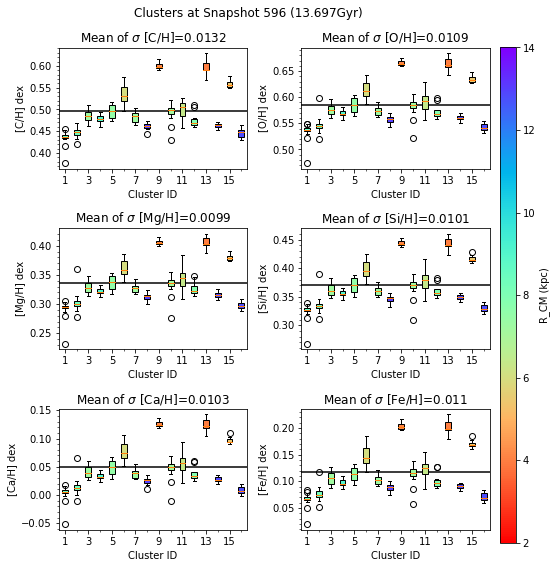

In [32]:
fig2=plt.figure(figsize=(7,8))

'''
ax_c=fig2.add_subplot(321)
ax_o=fig2.add_subplot(322)
ax_mg=fig2.add_subplot(323)
ax_si=fig2.add_subplot(324)
ax_ca=fig2.add_subplot(325)
ax_fe=fig2.add_subplot(326)
'''
cluster_id=np.arange(1,len(export_cluster)+1,1)

metals=["ch","oh","mgh","sih","cah","feh"]
metal_label=["[C/H]","[O/H]","[Mg/H]","[Si/H]","[Ca/H]","[Fe/H]"]

#to choose fixed colorbar for other plots lets choose vmin and vmax
vmin_rcm=2
vmax_rcm=14

colors=mcp.gen_color_normalized(cmap="rainbow",data_arr=cm_R,reverse=True,vmin=vmin_rcm,vmax=vmax_rcm)

x=np.arange(1,17,1)

for i in range(len(metals)):
    ax=fig2.add_subplot(3,2,i+1)
    all_metal=getmetal(export_cluster,metals[i])
    box=ax.boxplot(all_metal,patch_artist=True)
    cluster_means=[np.mean(each_cluster) for each_cluster in np.array(all_metal,dtype=list)]
    cluster_stds=[np.std(each_cluster)for each_cluster in np.array(all_metal,dtype=list)]
    ax.axhline(y=np.mean(cluster_means),c="black",label="Mean Metallicity")
    mean_std=np.mean(cluster_stds)
    ax.set_title(r"Mean of $\sigma$ "+metal_label[i]+"="+str(round(mean_std,4)))
    ax.set_xlabel("Cluster ID")
    ax.set_ylabel(metal_label[i]+str(" dex"))
    ax.minorticks_on()
    ax.set_xticks(x[::2])
    ax.set_xticklabels(x[::2], rotation=0)
    minor_locator = AutoMinorLocator(2)
    ax.xaxis.set_minor_locator(minor_locator)
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)


import matplotlib as mpl
ax = fig2.add_axes([1, 0.05, 0.03, 0.86]) #left, bottom, width, height
#norm=mpl.colors.Normalize(np.min(np.array(cm_R)), np.max(np.array(cm_R)))
norm=mpl.colors.Normalize(vmin_rcm,vmax_rcm)

cb = mpl.colorbar.ColorbarBase(ax, orientation='vertical',
        cmap=mpl.cm.rainbow_r,norm=norm
        ,label="R_CM (kpc)")

'''
ax_c.boxplot(getmetal(export_cluster,"ch"),patch_artist=True)
ax_o.boxplot(getmetal(export_cluster,"oh"),patch_artist=True)
ax_mg.boxplot(getmetal(export_cluster,"mgh"),patch_artist=True)
ax_si.boxplot(getmetal(export_cluster,"sih"),patch_artist=True)
ax_ca.boxplot(getmetal(export_cluster,"cah"),patch_artist=True)
ax_fe.boxplot(getmetal(export_cluster,"feh"),patch_artist=True)
'''
fig2.suptitle("Clusters at Snapshot "+str(snapnumber)+" ("+str(round(part.snapshot["time"],3))+"Gyr)")
fig2.tight_layout()
fig2.savefig("Metallicities_Clusters_with_R_CM"+str(snapnumber)+".jpg",bbox_inches="tight",dpi=200)


# Metallicites of the clusters color coded with Fe/H

0.067038834 0.2031616
[0.06703883 0.07636932 0.10631276 0.09697381 0.11358339 0.14877219
 0.10310096 0.08902174 0.2031616  0.11196036 0.1212231  0.1001995
 0.20209084 0.09073189 0.16946398 0.0708568  0.06       0.24      ]
0.06 0.24


<ipython-input-16-441e9c3d504b>:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig3.tight_layout()


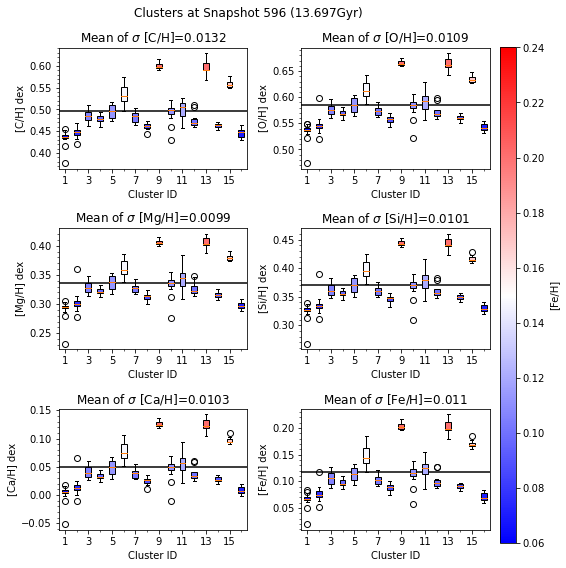

In [16]:
fig3=plt.figure(figsize=(7,8))

'''
ax_c=fig3.add_subplot(321)
ax_o=fig3.add_subplot(322)
ax_mg=fig3.add_subplot(323)
ax_si=fig3.add_subplot(324)
ax_ca=fig3.add_subplot(325)
ax_fe=fig3.add_subplot(326)
'''
cluster_id=np.arange(1,len(export_cluster)+1,1)

metals=["ch","oh","mgh","sih","cah","feh"]
metal_label=["[C/H]","[O/H]","[Mg/H]","[Si/H]","[Ca/H]","[Fe/H]"]

feh_clusters=getmetal(export_cluster,"feh")
feh_means=[np.mean(each_cluster) for each_cluster in np.array(feh_clusters,dtype=list)]
print(np.min(feh_means),np.max(feh_means))
vmin_fe=0.06
vmax_fe=0.24

colors_Fe_H=mcp.gen_color_normalized(cmap="bwr",data_arr=np.array(feh_means),vmin=vmin_fe,vmax=vmax_fe)

x=np.arange(1,17,1)


for i in range(len(metals)):
    ax=fig3.add_subplot(3,2,i+1)
    all_metal=getmetal(export_cluster,metals[i])
    box=ax.boxplot(all_metal,patch_artist=True)
    cluster_means=[np.mean(each_cluster) for each_cluster in np.array(all_metal,dtype=list)]
    cluster_stds=[np.std(each_cluster)for each_cluster in np.array(all_metal,dtype=list)]
    ax.axhline(y=np.mean(cluster_means),c="black",label="Mean Metallicity")
    mean_std=np.mean(cluster_stds)
    ax.set_title(r"Mean of $\sigma$ "+metal_label[i]+"="+str(round(mean_std,4)))
    ax.set_xlabel("Cluster ID")
    ax.set_ylabel(metal_label[i]+str(" dex"))
    ax.minorticks_on()
    ax.set_xticks(x[::2])
    ax.set_xticklabels(x[::2], rotation=0)
    minor_locator = AutoMinorLocator(2)
    ax.xaxis.set_minor_locator(minor_locator)
    
    for patch, color in zip(box['boxes'], colors_Fe_H):
        patch.set_facecolor(color)


import matplotlib as mpl
ax = fig3.add_axes([1, 0.05, 0.03, 0.86]) #left, bottom, width, height
#norm=mpl.colors.Normalize(np.min(np.array(feh_means)), np.max(np.array(feh_means)))
norm=mpl.colors.Normalize(vmin_fe,vmax_fe)

cb = mpl.colorbar.ColorbarBase(ax, orientation='vertical',
        cmap=mpl.cm.bwr,norm=norm
        ,label="[Fe/H]")

'''
ax_c.boxplot(getmetal(export_cluster,"ch"),patch_artist=True)
ax_o.boxplot(getmetal(export_cluster,"oh"),patch_artist=True)
ax_mg.boxplot(getmetal(export_cluster,"mgh"),patch_artist=True)
ax_si.boxplot(getmetal(export_cluster,"sih"),patch_artist=True)
ax_ca.boxplot(getmetal(export_cluster,"cah"),patch_artist=True)
ax_fe.boxplot(getmetal(export_cluster,"feh"),patch_artist=True)
'''
fig3.suptitle("Clusters at Snapshot "+str(snapnumber)+" ("+str(round(part.snapshot["time"],3))+"Gyr)")
fig3.tight_layout()
fig3.savefig("Metallicities_Clusters_with_Fe_H"+str(snapnumber)+".jpg",bbox_inches="tight",dpi=200)


# R_CM vs Cluster ID color coded by metallicity and sized by mass

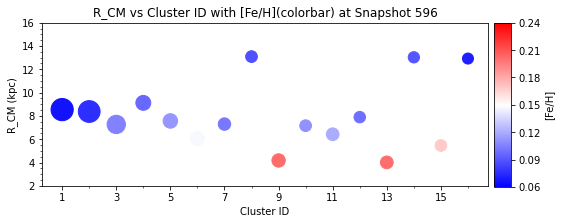

In [19]:
from matplotlib.ticker import AutoMinorLocator


#Getting the mass of all clusters in  a list

all_mass=list()
for cluster_group in export_cluster:
    mass_data=export_cluster[cluster_group]["mtot"]
    all_mass.append(mass_data)
#print(all_mass)

fig5=plt.figure(figsize=(8,3))
cluster_id=np.arange(1,len(export_cluster)+1,1)
ax=fig5.add_subplot(1,1,1)

x=np.arange(1,17,1)

ax.set_title("R_CM vs Cluster ID with [Fe/H](colorbar) at Snapshot "+str(snapnumber))
ax.set_xlabel("Cluster ID")
ax.set_ylabel("R_CM (kpc)")
ax.minorticks_on()
ax.set_xticks(x[::2])
ax.set_xticklabels(x[::2], rotation=0)
minor_locator = AutoMinorLocator(2)
ax.xaxis.set_minor_locator(minor_locator)
ax.scatter(x,cm_R,c=colors_Fe_H,s=np.array(all_mass)/1e3)
ax.set_ylim(2,16)

import matplotlib as mpl
cax = fig5.add_axes([0.91, 0.12, 0.03, 0.76]) #left, bottom, width, height
norm=mpl.colors.Normalize(vmin_fe,vmax_fe)
cbarticks = np.arange(vmin_fe,vmax_fe+0.03,0.03)

cb = mpl.colorbar.ColorbarBase(cax, orientation='vertical',
        cmap=mpl.cm.bwr,norm=norm
        ,label="[Fe/H]",ticks=cbarticks)
fig5.savefig("Cluster_ID_vs_R_CM_with_Fe_H"+str(snapnumber)+".jpg",bbox_inches="tight",dpi=200)


In [33]:
export_cluster[1].keys()

dict_keys(['cluster_groupid', 'no_of_star', 'id', 'id_children', 'xcm', 'ycm', 'zcm', 'mtot', 'r90', 'r50', 'rmax', 'x', 'y', 'z', 'age', 'feh', 'mgh', 'ch', 'nh', 'oh', 'neh', 'sih', 'sh', 'cah', 'mgfe', 'ofe', 'sife', 'sfe', 'cafe', 'nefe'])